## Check Data availability

It was noticed that the dataset used for this assignment was marked as number k397-673e

In [1]:
from openclean.data.source.socrata import Socrata

for dataset in Socrata().catalog(domain='data.cityofnewyork.us'):
    if 'citywide' in dataset.name.lower() and 'payroll' in dataset.name.lower():
        print(f'{dataset.identifier}\t{dataset.domain}\t{dataset.name}')

k397-673e	data.cityofnewyork.us	Citywide Payroll Data (Fiscal Year)


## Download Data

In [2]:
import gzip
import humanfriendly
import os

dataset = Socrata().dataset('k397-673e')
datafile = './k397-673e.tsv.gz'

if not os.path.isfile(datafile):
    with gzip.open(datafile, 'wb') as f:
        print('Downloading ...\n')
        dataset.write(f)
        
fsize = humanfriendly.format_size(os.stat(datafile).st_size)
print("Using '{}' in file {} of size {}".format(dataset.name, datafile, fsize))

Using 'Citywide Payroll Data (Fiscal Year)' in file ./k397-673e.tsv.gz of size 89.62 MB


## Read Data as Pandas DataFrame

In [3]:
from openclean.pipeline import stream
from openclean.data.load import dataset

ds_full = dataset(datafile)

## Set Pandas options

In jupyter notebook, Pandas DataFrame did not print all the row data, hence in this experiment, the option was set to print all the rows of current dataset

In [4]:
import pandas as pd

pd.set_option('display.max_rows', None)

## Profiling original dataset

Before we start, the original dataset should be profiled which was used to do comparsion after data cleaning

1. Print the number of rows
2. Print small data sample of the dataset
3. Generate data profile to locate the missing values and other abnormal data
4. Profiling data types in the dataset

In [5]:
# print the total number of data contained in the dataset
print(f'{len(ds_full):,} rows.')

3,923,290 rows.


In [6]:
# Print small data samples
ds_full.head(10)

,Fiscal Year,Payroll Number,Agency Name,Last Name,First Name,Mid Init,Agency Start Date,Work Location Borough,Title Description,Leave Status as of June 30,Base Salary,Pay Basis,Regular Hours,Regular Gross Paid,OT Hours,Total OT Paid,Total Other Pay
0,2020,17,OFFICE OF EMERGENCY MANAGEMENT,BEREZIN,MIKHAIL,,08/10/2015,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.00,per Annum,1820,84698.21,0,0.00,0.00
1,2020,17,OFFICE OF EMERGENCY MANAGEMENT,GEAGER,VERONICA,M,09/12/2016,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.00,per Annum,1820,84698.21,0,0.00,0.00
2,2020,17,OFFICE OF EMERGENCY MANAGEMENT,RAMANI,SHRADDHA,,02/22/2016,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.00,per Annum,1820,84698.21,0,0.00,0.00
3,2020,17,OFFICE OF EMERGENCY MANAGEMENT,ROTTA,JONATHAN,D,09/16/2013,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.00,per Annum,1820,84698.21,0,0.00,0.00
4,2020,17,OFFICE OF EMERGENCY MANAGEMENT,WILSON II,ROBERT,P,04/30/2018,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.00,per Annum,1820,84698.21,0,0.00,0.00
5,2020,17,OFFICE OF EMERGENCY MANAGEMENT,WASHINGTON,MORIAH,A,03/18/2019,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.00,per Annum,1820,87900.95,0,0.00,-3202.74
6,2020,17,OFFICE OF EMERGENCY MANAGEMENT,VAZQUEZ,MARGARET,,09/29/2008,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,94415.00,per Annum,1820,84312.72,0,0.00,0.00
7,2020,17,OFFICE OF EMERGENCY MANAGEMENT,KRAWCZYK,AMANDA,N,05/15/2017,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.00,per Annum,1820,83976.54,0,0.00,0.00
8,2020,17,OFFICE OF EMERGENCY MANAGEMENT,MURRELL,JALEESA,S,12/01/2014,BROOKLYN,EMERGENCY PREPAREDNESS MANAGER,ACTIVE,86005.00,per Annum,1820,83877.36,0,0.00,0.00
9,2020,17,OFFICE OF EMERGENCY MANAGEMENT,DE LOS SANTOS,JANIRA,,06/05/2017,BROOKLYN,EMERGENCY PREPAREDNESS SPECIALIST,ACTIVE,67676.00,per Annum,1820,66647.77,348.5,16572.64,144.15


## Locate missing values & Check data type

It was noticed that there were empty values for payroll number, names, work location borough and title description, which should be fixed during data cleaning procedure

Before the data cleaning procedure, all the data types of columns should be confirmed

In [7]:
from openclean.profiling.column import DefaultColumnProfiler
from openclean.profiling.dataset import dataset_profile

profiles = dataset_profile(ds_full)

In [8]:
# Preview the dataset

print(profiles.stats())

                              total    empty  distinct  uniqueness    entropy
Fiscal Year                 3923290        0         7    0.000002   2.805614
Payroll Number              3923290  1745440       157    0.000072   4.286506
Agency Name                 3923290        0       165    0.000042   4.365925
Last Name                   3923290     2031    157080    0.040059  14.264455
First Name                  3923290     2033     88232    0.022501  11.611521
Mid Init                    3923290  1596166        43    0.000018   4.073274
Agency Start Date           3923290       63     14933    0.003806  11.097847
Work Location Borough       3923290   506226        22    0.000006   1.507244
Title Description           3923290       84      1802    0.000459   6.207524
Leave Status as of June 30  3923290        0         5    0.000001   0.710495
Base Salary                 3923290        0     98573    0.025125  10.224240
Pay Basis                   3923290        0         4    0.0000

It was noticed that for columns "Payroll Number", "Last Name", "First Name", "Mid Init", "Work Location Borough" and "Title Description", there were missing values. In out strategy, missing values were not allowed, hence in next few steps, data cleaning would be performed to clean the missing data with proper values from column to column

In [9]:
# Confirm data types

print(profiles.types())

                             date    float   int     str
Fiscal Year                     0        0     7       0
Payroll Number                  0        0   157       0
Agency Name                     0        0     0     165
Last Name                       0        1     1  157078
First Name                      0        2     0   88230
Mid Init                        0        0     9      34
Agency Start Date           14933        0     0       0
Work Location Borough           0        0     0      22
Title Description               0        0     0    1802
Leave Status as of June 30      0        0     0       5
Base Salary                     0    98573     0       0
Pay Basis                       0        0     0       4
Regular Hours                   0    83708  2393       0
Regular Gross Paid              0  1785527     0       0
OT Hours                        0    51067  1552       0
Total OT Paid                   0   806992     0       0
Total Other Pay                

It was noticed that for numeric values such as hours and paid, most of the values were defined as float. Hence in out data clean job, these columns were handled in float format by default

## Profiling the data of "Fiscal Year" Column

For the first column "Fiscal Year", since there was no missing value, we should check the distribution of the fiscal year of the dataset

To check whether there was outlier or error values for the fiscal year column

In [10]:
# Define matplotlib visualisation function

COLUMNS = [
    "Fiscal Year",
    "Payroll Number",
    "Agency Name",
    "Last Name",
    "First Name",
    "Mid Init",
    "Agency Start Date",
    "Work Location Borough",
    "Title Description",
    "Leave Status as of June 30",
    "Base Salary",
    "Pay Basis",
    "Regular Hours",
    "Regular Gross Paid",
    "OT Hours",
    "Total OT Paid",
    "Total Other Pay"
]

%matplotlib inline
import matplotlib.pyplot as plt

def log_histogram(ax, x, name, color, b_size, y_scale):
    ax.set_xlabel(f'values: {name}')
    ax.set_ylabel('count (%s)' % y_scale)
    if y_scale == 'log': 
        ax.set_yscale(y_scale, base = 10) 
    else: 
        ax.set_yscale(y_scale)
    _ = ax.hist(x, bins=b_size, color=color)
    
def log_histogram_horizontal(ax, y, name, color, b_size):
    ax.set_ylabel(f'label: {name}')
    ax.set_xlabel('count (log10)')
    ax.set_xscale('log', base=10)
    _ = ax.hist(y, bins=b_size, color=color, orientation=u'horizontal')
    
def pie_chart(ax, x, x_index):
    ax.pie(x, labels=x_index, autopct='%1.1f%%',shadow=True, startangle=90)
    ax.axis('equal')

2019    592431
2020    590210
2015    577880
2017    562266
2018    546161
2016    544817
2014    509525
Name: Fiscal Year, dtype: int64


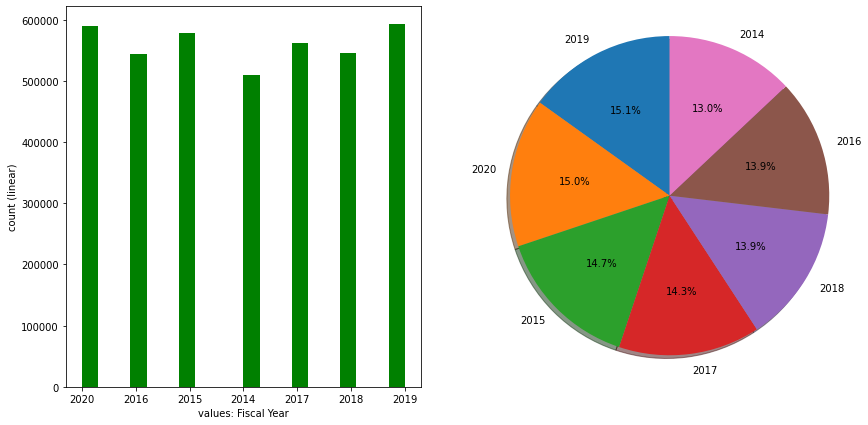

In [11]:
fiscal_year = ds_full['Fiscal Year'].value_counts()
print(fiscal_year)

fig, ax = plt.subplots(1, 2, figsize=(14,7))
log_histogram(ax[0], ds_full['Fiscal Year'], 'Fiscal Year', 'green', 20, 'linear')
pie_chart(ax[1], fiscal_year.values, fiscal_year.keys().values)

In the original dataset, there was no abnormal / missing values in column "Fiscal Year", hence our strategy was keep it as it was in original dataset

## Data profiling & cleaning for column "Work Location Borough"

From the profiling result for the whole dataset in the previous sections, total 506,226 rows of work location borough were empty, we printed out the original values and noticed that total 83688 rows were with OTHER value

We also noticed that there were work location in title case or lower case, hence we formatted it into upper case as the most locations

In our strategy, during data cleaning, we filled the work location borough with empty value by OTHER

And we also implemented data reference to check the correctness of the borough name, if the borough does not exist, it should be other

In [12]:
work_loc = ds_full['Work Location Borough'].value_counts()

print(work_loc)
print("Total locations: ", len(work_loc))

MANHATTAN        2394979
                  506226
QUEENS            379695
BROOKLYN          323565
BRONX             177881
OTHER              83688
RICHMOND           46156
WESTCHESTER         3417
ULSTER              1953
Manhattan           1622
Bronx                935
SULLIVAN             822
Queens               660
DELAWARE             551
NASSAU               245
PUTNAM               243
SCHOHARIE            175
DUTCHESS             140
Richmond             112
ALBANY                95
GREENE                61
WASHINGTON DC         47
ORANGE                22
Name: Work Location Borough, dtype: int64
Total locations:  23


Data would be cleaned in the next step

All the rows with empty work location was categorized into OTHER

It was noticed that for some categories such as Richmod, Bronx and Queens, the data representation was not in an uniformed format.

They were fixed by updating these rows with title format to upper case

We also visualised the column

MANHATTAN        2396601
OTHER             589914
QUEENS            380355
BROOKLYN          323565
BRONX             178816
RICHMOND           46268
WESTCHESTER         3417
ULSTER              1953
SULLIVAN             822
DELAWARE             551
NASSAU               245
PUTNAM               243
SCHOHARIE            175
DUTCHESS             140
ALBANY                95
GREENE                61
WASHINGTON DC         47
ORANGE                22
Name: Work Location Borough, dtype: int64
Total locations:  18


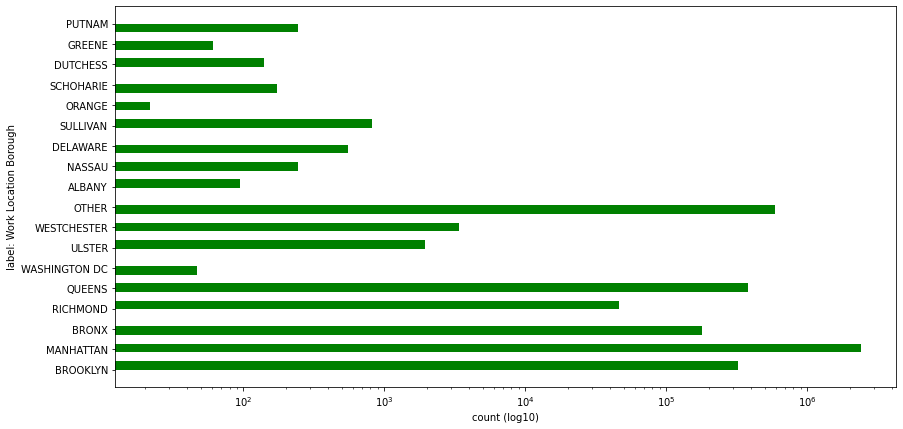

In [13]:
from openclean.function.value.null import is_empty
from openclean.operator.transform.update import update

ds_full = update(ds_full, columns='Work Location Borough', func=str.upper)
ds_full = update(ds_full, columns='Work Location Borough', func=lambda x: 'OTHER' if is_empty(x) else x)
work_loc = ds_full['Work Location Borough'].value_counts()

print(work_loc)
print("Total locations: ", len(work_loc))

fig, ax = plt.subplots(1, 1, figsize=(14,7))
log_histogram_horizontal(ax, ds_full['Work Location Borough'], 'Work Location Borough', 'green', 40)

We've cleaned the column "Work Location Borough", all the missing values were eliminated and all the location values were uniformed as upper case

## Data profiling & cleaning for column "Title Description"

Same as column 'Work Location Borough', according to the stats, and also some titles were not in upper case.

There are also 84 rows in 'Title Description', we merged it with value 'UNKNOWN' and update the value with upper case

It was also noticed that for some titles, there were special characters '*' and '?' at the beginning

We cleaned these characters with strip function

In [14]:
# First we profile the column in the original dataset
import re
titles = ds_full['Title Description'].value_counts()
print(titles)
print("Total titles: ", len(titles))

TEACHER- PER SESSION                                            594024
TEACHER                                                         435112
ELECTION WORKER                                                 232159
ANNUAL ED PARA                                                  191944
TEACHER SPECIAL EDUCATION                                       181519
POLICE OFFICER                                                  180668
TEACHER-GENERAL ED                                               84260
CORRECTION OFFICER                                               69696
FIREFIGHTER                                                      62057
F/T SCHOOL AIDE                                                  58867
JOB TRAINING PARTICIPANT                                         55701
SUBSTITUTE ED PARA                                               51345
SANITATION WORKER                                                47151
COMMUNITY ASSOCIATE                                              40638
SCHOOL

it was noticed that some values was started with special characters, which should be fixed. All the empty values were defined as "UNKNOWN" and all the values were uniformed into uppercase

In [15]:
ds_full = update(ds_full, columns='Title Description', func=str.upper)
ds_full = update(ds_full, columns='Title Description', func=lambda x: 'UNKNOWN' if is_empty(x) else x)
ds_full = update(ds_full, columns='Title Description', func=lambda x: re.sub("^[*\?]*", "", str(x)))
titles = ds_full['Title Description'].value_counts()
print(titles)
print("Total titles: ", len(titles))

TEACHER- PER SESSION                                            594024
TEACHER                                                         435112
ELECTION WORKER                                                 232159
ANNUAL ED PARA                                                  191944
TEACHER SPECIAL EDUCATION                                       181519
POLICE OFFICER                                                  180668
TEACHER-GENERAL ED                                               84260
CORRECTION OFFICER                                               69696
FIREFIGHTER                                                      62057
F/T SCHOOL AIDE                                                  58867
JOB TRAINING PARTICIPANT                                         55701
SUBSTITUTE ED PARA                                               51345
SANITATION WORKER                                                47151
COMMUNITY ASSOCIATE                                              40638
SCHOOL

## Data profiling for column "Leave Status as of June 30"

It was noticed that there was no row for column "Leave Status as of June 30" was empty.

Hence the value counts of this column was printed. No data were cleaned

ACTIVE                 3355483
CEASED                  485414
ON LEAVE                 42401
SEASONAL                 33451
ON SEPARATION LEAVE       6541
Name: Leave Status as of June 30, dtype: int64
Total status:  5


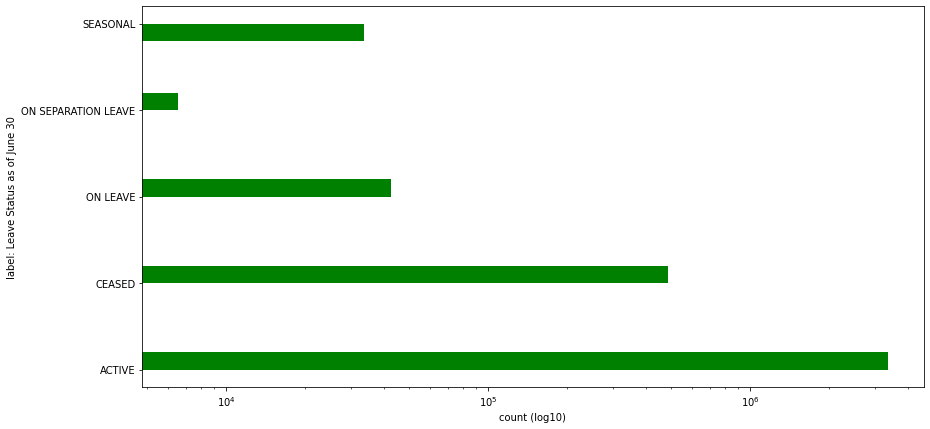

In [16]:
status = ds_full['Leave Status as of June 30'].value_counts()
print(status)
print("Total status: ", len(status))

fig, ax = plt.subplots(1, 1, figsize=(14,7))
log_histogram_horizontal(ax, ds_full['Leave Status as of June 30'], 'Leave Status as of June 30', 'green', 20)

## Data profiling & cleaning for column "Payroll Number" and "Agency Name"

For some rows in column "Payroll Number", the values were missing

It was noticed that the values in column "Payroll Number" was bundled with the column "Agency Name"
Hence for the missing value in "Payroll Number", we cleaned these values according to the existing mapping values of "Agency Name"

It was noticed the representation for some agency name in the dataset was different, hence we filtered these agency names and mapped them to the agency name which was correct (with non-empty payroll number)
For payroll number without any recording, they were marked as -1

It was noticed that there were some agency names with title or lower case
Hence our strategy for column "Agency Name" was to update the name with upper case

In [17]:
payroll_agency = ds_full[["Payroll Number", "Agency Name"]].value_counts()

print(payroll_agency)
print("Total value count: ", len(payroll_agency))

Payroll Number  Agency Name                   
742             DEPT OF ED PEDAGOGICAL            435611
747             DEPT OF ED PER SESSION TEACHER    364198
                DEPT OF ED PEDAGOGICAL            322749
                DEPT OF ED PER SESSION TEACHER    244367
                POLICE DEPARTMENT                 187648
56              POLICE DEPARTMENT                 180097
744             DEPT OF ED PARA PROFESSIONALS     146006
300             BOARD OF ELECTION POLL WORKERS    134176
                BOARD OF ELECTION POLL WORKERS    101059
                DEPT OF ED PARA PROFESSIONALS      99253
745             DEPT OF ED HRLY SUPPORT STAFF      90119
                DEPT OF ED HRLY SUPPORT STAFF      74046
57              FIRE DEPARTMENT                    72818
740             DEPARTMENT OF EDUCATION ADMIN      64167
846             DEPT OF PARKS & RECREATION         61689
69              HRA/DEPT OF SOCIAL SERVICES        58051
                FIRE DEPARTMENT          

Next we will clean the data by filling the missing values in "Payroll Number" column, and format the values in "Agency Name" into uppercase

In [18]:
payroll_dict = {}
DA_matcher = {"MANHATTAN DA": "DISTRICT ATTORNEY-MANHATTAN", "KINGS DA": "DISTRICT ATTORNEY KINGS COUNTY", "BRONX DA": "BRONX DISTRICT ATTORNEY", "QUEENS DA": "DISTRICT ATTORNEY QNS COUNTY", "SPEC NARCS-DA": "DISTRICT ATTORNEY-SPECIAL NARC", "RICHMOND DA": "DISTRICT ATTORNEY RICHMOND COU"}

ds_full = update(ds_full, columns='Agency Name', func=str.upper)
ds_full = update(ds_full, columns='Agency Name', func=lambda x: DA_matcher[str(x)] if str(x) in DA_matcher else x)

payroll_agency_map = ds_full[['Agency Name', 'Payroll Number']].value_counts()
for agency, payroll in payroll_agency_map.keys():
    if str(payroll) != "":
        payroll_dict[agency] = payroll

def match_payroll(agency):
    return payroll_dict[agency] if agency in payroll_dict else -1

ds_full["Payroll Number"] = ds_full["Agency Name"].map(match_payroll)
payroll_agency = ds_full[["Payroll Number", "Agency Name"]].value_counts()

print(payroll_agency)
print("Total value count: ", len(payroll_agency))

Payroll Number  Agency Name                   
742             DEPT OF ED PEDAGOGICAL            758360
747             DEPT OF ED PER SESSION TEACHER    608565
56              POLICE DEPARTMENT                 423364
744             DEPT OF ED PARA PROFESSIONALS     245259
300             BOARD OF ELECTION POLL WORKERS    235235
745             DEPT OF ED HRLY SUPPORT STAFF     164165
57              FIRE DEPARTMENT                   128819
846             DEPT OF PARKS & RECREATION        117212
740             DEPARTMENT OF EDUCATION ADMIN     110936
69              HRA/DEPT OF SOCIAL SERVICES       104331
996             NYC HOUSING AUTHORITY              95132
827             DEPARTMENT OF SANITATION           92755
72              DEPARTMENT OF CORRECTION           91843
746             DEPT OF ED PER DIEM TEACHERS       90784
816             DEPT OF HEALTH/MENTAL HYGIENE      54291
67              ADMIN FOR CHILDREN'S SVCS          53268
826             DEPT OF ENVIRONMENT PROTE

## Data profiling for hours and amount paid

### Basic statistics

Show statistics including min, max, mean and median for salary and working hours.

Firstly, we can see there're 4 types of Pay Basis. According to column information from dataset: "Regular Hours", "Regular Gross Paid", "OT Hours", "Total OT Paid" and "Total Other Pay" are counted in fiscal year, so we can directly profile these data. However, Base Salary may be different for each kind of Pay Basis. In this case we should profile Base Salary for each Pay Basis respectively.

In [19]:
pay_basis_cnt = ds_full['Pay Basis'].value_counts()
print(pay_basis_cnt)
PAY_BASES = list(pay_basis_cnt.index)
print("Total pay basis type: ", len(pay_basis_cnt))

per Annum          2340656
per Day             864431
per Hour            699600
Prorated Annual      18603
Name: Pay Basis, dtype: int64
Total pay basis type:  4


In [20]:
# Print min, max, mean and median for hours and paid 

STAT_COLS = [
    "Base Salary",
    "Regular Hours",
    "Regular Gross Paid",
    "OT Hours",
    "Total OT Paid",
    "Total Other Pay"
]

# change type to float to improve performance
ds_full = ds_full.astype({c:'float32' for c in STAT_COLS}, copy=False)

In [21]:
print(f'{"":<32} {"min":<12} {"max":<12} {"mean":<12} {"median"}')

# Base Salary for each Pay Basis
c = STAT_COLS[0]
for pb in PAY_BASES:
    df_col = ds_full[ds_full['Pay Basis'] == pb][c]
    stat = (df_col.min(), df_col.max(), df_col.mean(), df_col.median())
    print(f'{f"{c} ({pb})":<32} {stat[0]:<12.2f} {stat[1]:<12.2f} {stat[2]:<12.2f} {stat[3]:.2f}')

# Other columns don't have to profile respectively
for c in STAT_COLS[1:]:
    df_col = ds_full[c]
    stat = (df_col.min(), df_col.max(), df_col.mean(), df_col.median())
    print(f'{c:<32} {stat[0]:<12.2f} {stat[1]:<12.2f} {stat[2]:<12.2f} {stat[3]:.2f}')

                                 min          max          mean         median
Base Salary (per Annum)          1.00         414707.00    71774.66     70789.00
Base Salary (per Day)            0.01         999.90       80.72        33.18
Base Salary (per Hour)           0.50         160683.39    576.66       12.85
Base Salary (Prorated Annual)    2090.00      165090.00    31949.62     30425.00
Regular Hours                    -1260.00     4171.43      668.12       0.00
Regular Gross Paid               -76223.05    672308.88    41976.71     35969.21
OT Hours                         -209.00      3347.50      60.54        0.00
Total OT Paid                    -26493.88    237389.73    3265.65      0.00
Total Other Pay                  -281595.03   650000.00    2509.77      0.93


### Histogram

Basic statistics may not be enough to get a good understanding of numeric data, while visualized hitogram can give us better insight. It may also help us decide what kinds of hours or salary are considered "outliers".

Because the total number of rows are very large, we use log scale for histogram.

In [22]:
def log_histogram_simple(ax, x, name, color):
    ax.set_xlabel(f'values: {name}')
    ax.set_ylabel('count (log10)')
    ax.set_yscale('log', base=10)
    _ = ax.hist(x, bins=100, color=color)

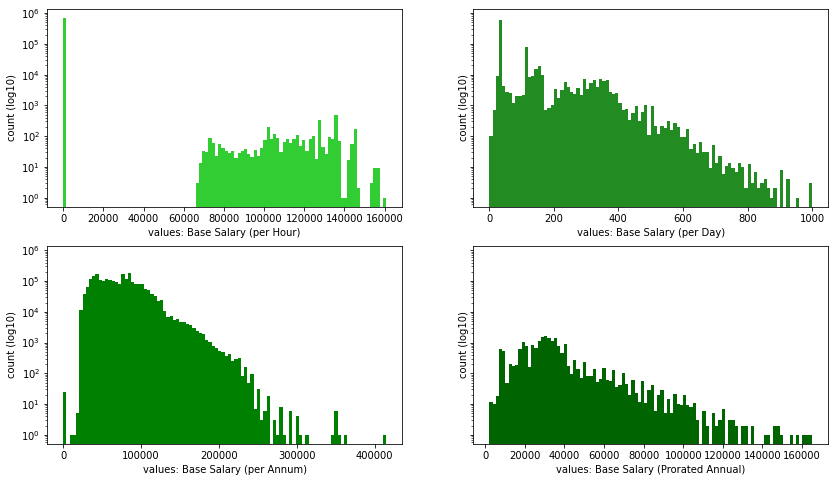

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(14,8), sharey=True)
log_histogram_simple(ax[0, 0], ds_full[ds_full['Pay Basis'] == 'per Hour']['Base Salary'], 'Base Salary (per Hour)', 'limegreen')
log_histogram_simple(ax[0, 1], ds_full[ds_full['Pay Basis'] == 'per Day']['Base Salary'], 'Base Salary (per Day)', 'forestgreen')
log_histogram_simple(ax[1, 0], ds_full[ds_full['Pay Basis'] == 'per Annum']['Base Salary'], 'Base Salary (per Annum)', 'green')
log_histogram_simple(ax[1, 1], ds_full[ds_full['Pay Basis'] == 'Prorated Annual']['Base Salary'], 'Base Salary (Prorated Annual)', 'darkgreen')

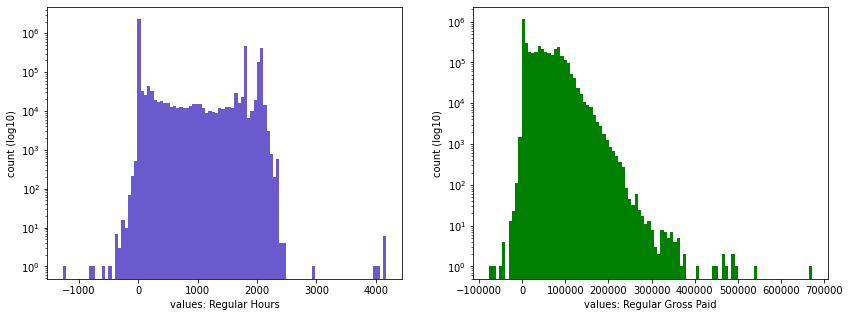

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
log_histogram_simple(ax[0], ds_full['Regular Hours'], 'Regular Hours', 'slateblue')
log_histogram_simple(ax[1], ds_full['Regular Gross Paid'], 'Regular Gross Paid', 'green')

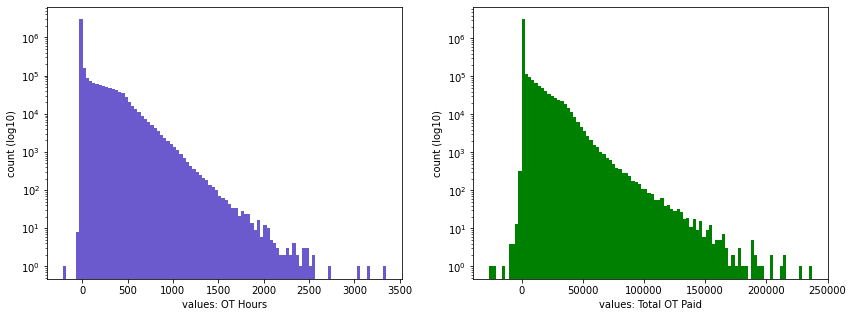

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
log_histogram_simple(ax[0], ds_full['OT Hours'], 'OT Hours', 'slateblue')
log_histogram_simple(ax[1], ds_full['Total OT Paid'], 'Total OT Paid', 'green')

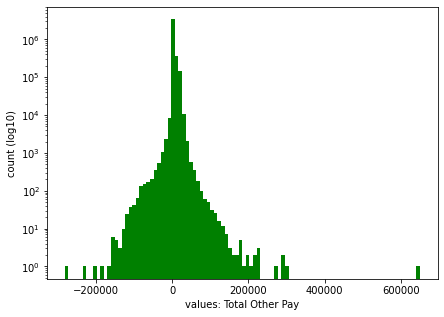

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
log_histogram_simple(ax, ds_full['Total Other Pay'], 'Total Other Pay', 'green')

## Outliers & data cleaning for hours and paid

As shown in the histograms, there're some negative numbers exist. Among these columns, "Regular Hours", "Regular Gross Paid", "OT Hours" and "Total OT Paid" shouldn't have negative numbers using our common sense. However, some sources suggest that negative numbers are used for correcting previous payroll data in some cases. Thus we still need more analysis to determine whether these data are outliers.

One possible analysis is to count the negative numbers by column "Fiscal Year" or "Agency Name" and see whether there's any relation between them.

In [29]:
df_neg = ds_full[
    (ds_full['Regular Hours'] < 0)
    | (ds_full['Regular Gross Paid'] < 0)
    | (ds_full['OT Hours'] < 0)
    | (ds_full['Total OT Paid'] < 0)]
print(f'Number of rows containing negative numbers: {df_neg.shape[0]}')

Number of rows containing negative numbers: 5619


In [30]:
df_neg['Fiscal Year'].value_counts()

2020    2481
2018    1007
2016     554
2017     439
2019     425
2015     368
2014     345
Name: Fiscal Year, dtype: int64

In [31]:
df_neg['Agency Name'].value_counts()

POLICE DEPARTMENT                 836
DEPT OF ED PEDAGOGICAL            733
HRA/DEPT OF SOCIAL SERVICES       598
NYC HOUSING AUTHORITY             422
DEPT OF HEALTH/MENTAL HYGIENE     331
DEPARTMENT OF EDUCATION ADMIN     284
DEPT OF ENVIRONMENT PROTECTION    247
DEPT. OF HOMELESS SERVICES        213
DEPT OF ED PARA PROFESSIONALS     192
DEPT OF PARKS & RECREATION        179
DEPT OF ED HRLY SUPPORT STAFF     179
ADMIN FOR CHILDREN'S SVCS         171
DEPARTMENT OF CORRECTION          167
DEPARTMENT OF SANITATION          160
FIRE DEPARTMENT                   144
DEPARTMENT OF TRANSPORTATION      106
COMMUNITY COLLEGE (MANHATTAN)      81
DEPARTMENT OF BUILDINGS            62
COMMUNITY COLLEGE (LAGUARDIA)      59
DEPT OF ED PER SESSION TEACHER     58
HOUSING PRESERVATION & DVLPMNT     43
COMMUNITY COLLEGE (BRONX)          38
DEPT OF CITYWIDE ADMIN SVCS        38
COMMUNITY COLLEGE (KINGSBORO)      26
COMMUNITY COLLEGE (HOSTOS)         19
DEPARTMENT OF PROBATION            16
DEPT OF INFO

Comparing the output with previous profiling counting step suggests that: the number of rows containing negative numbers is loosely connected to the total number of rows for each "Fiscal Year" or "Agency Name". That is to say, the more rows in total, the more rows containing negative numbers.

So there's no significant probability difference of negative rows for each column, we can safely conclude that these negative rows are outliers, and may be removed.

We regarded the rows with negative numbers were incorrect values, hence these rows were droped

In [32]:
ds_full.drop(df_neg.index, inplace=True)

## Profiling & cleaning for names

It was noticed that some names were empty in the original dataset.

However, the aim of this dataset was to profiling the hours and paid. Which means the name was little incluence of the data we calculated. Hence our strategy was just ignore the empty name and filled these rows with character '/'. Since non-empty value was one of the requirement of openclean library's notebook.

In [33]:
ds_full = update(ds_full, columns='Last Name', func=str.upper)
ds_full = update(ds_full, columns='Last Name', func=lambda x: '/' if is_empty(x) else x)

ds_full = update(ds_full, columns='First Name', func=str.upper)
ds_full = update(ds_full, columns='First Name', func=lambda x: '/' if is_empty(x) else x)

ds_full = update(ds_full, columns='Mid Init', func=str.upper)
ds_full = update(ds_full, columns='Mid Init', func=lambda x: '/' if is_empty(x) else x)

### K-Clusters for the employee names



In [36]:
from openclean.cluster.key import KeyCollision
from openclean.function.value.key.fingerprint import Fingerprint

last_names = ds_full['Last Name'].value_counts()
clusters = KeyCollision(func=Fingerprint()).clusters(last_names)
first_names = ds_full['First Name'].value_counts()
clusters = KeyCollision(func=Fingerprint()).clusters(first_names)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [34]:
def print_k_clusters(clusters, k=5):
    clusters = sorted(clusters, key=lambda x: len(x), reverse=True)
    val_count = sum([len(c) for c in clusters])
    print('Total number of clusters is {} with {} values'.format(len(clusters), val_count))
    for i in range(min(k, len(clusters))):
        print('\nCluster {}'.format(i + 1))
        for key, cnt in clusters[i].items():
            if key == '':
                key = "''"
            print(f'  {key} (x {cnt})')
print_k_clusters(clusters)

NameError: name 'clusters' is not defined

## Profiling & cleaning for column "Agency Start Date"

For our Strategy, we first identify the min and max of this column and we do the visulization of this column.

### Check "Agency Start Date" data

First we profile the minmax of Agency Start Date, it was noticed that the min value was 1901-01-01 and the max value was 9999-12-31, which was abnormal. Hence this column was visualised and cleaned.

In [37]:
profiles.minmax('Agency Start Date')

,min,max
date,1901-01-01,9999-12-31 00:00:00


In [ ]:
from openclean.function.value.null import is_empty
from openclean.operator.transform.update import update
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.boxplots(figsize=(14,7))
log_boxplot(ax, ds_full['Agency Start Date'], 'Agency Start Date', 'green')